<a href="https://colab.research.google.com/github/konan0802/100knock-data-analytics/blob/main/4%E7%AB%A0_%E9%A1%A7%E5%AE%A2%E3%81%AE%E8%A1%8C%E5%8B%95%E3%82%92%E4%BA%88%E6%B8%AC%E3%81%99%E3%82%8B%EF%BC%91%EF%BC%90%E6%9C%AC%E3%83%8E%E3%83%83%E3%82%AF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [75]:
# Google Driveと接続を行います。これを行うことで、Driveにあるデータにアクセスできるようになります。
# 下記セルを実行すると、Googleアカウントのログインを求められますのでログインしてください。
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [76]:
# 作業フォルダへの移動を行います。
# 人によって作業場所がことなるので、その場合作業場所を変更してください。
import os
os.chdir('/content/drive/MyDrive/100knock-data_analytics/4章') #ここを変更。

# 4章 顧客の全体像を把握する１０本ノック

引き続き、スポーツジムの会員データを使って顧客の行動を分析していきます。  
３章で顧客の全体像を把握しました。  
ここからは、機械学習を用いて顧客のグループ化や顧客の利用予測行なっていきましょう。  
ここでは、教師なし学習、教師あり学習の回帰を取り扱います。

### ノック31：データを読み込んで確認しよう

In [77]:
import pandas as pd
uselog = pd.read_csv('use_log.csv')
uselog.isnull().sum()

,0
log_id,0
customer_id,0
usedate,0


In [78]:
customer = pd.read_csv('customer_join.csv')
customer.isnull().sum()

,0
customer_id,0
name,0
class,0
gender,0
start_date,0
end_date,2842
campaign_id,0
is_deleted,0
class_name,0
price,0


### ノック32：クラスタリングで顧客をグループ化しよう

In [79]:
customer_clustering = customer[["mean", "median", "max", "min", "membership_period"]]
customer_clustering.head()

,mean,median,max,min,membership_period
0,4.833333,5.0,8,2,47
1,5.083333,5.0,7,3,47
2,4.583333,5.0,6,3,47
3,4.833333,4.5,7,2,47
4,3.916667,4.0,6,1,47


In [80]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
customer_clustering_sc = sc.fit_transform(customer_clustering)

kmeans = KMeans(n_clusters=4, random_state=0)
clusters = kmeans.fit(customer_clustering_sc)
customer_clustering = customer_clustering.assign(cluster=clusters.labels_)
print(customer_clustering["cluster"].unique())
customer_clustering.head()

[3 2 0 1]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,mean,median,max,min,membership_period,cluster
0,4.833333,5.0,8,2,47,3
1,5.083333,5.0,7,3,47,3
2,4.583333,5.0,6,3,47,3
3,4.833333,4.5,7,2,47,3
4,3.916667,4.0,6,1,47,3


### ノック33：クラスタリング結果を分析しよう

In [81]:
customer_clustering.columns = ["月内平均値", "月内中央値", "月内最大値", "月内最小値", "会員期間", "cluster"]
customer_clustering.groupby("cluster").count()

,月内平均値,月内中央値,月内最大値,月内最小値,会員期間
cluster,,,,,
0,1334,1334,1334,1334,1334
1,846,846,846,846,846
2,763,763,763,763,763
3,1249,1249,1249,1249,1249


In [82]:
customer_clustering.groupby("cluster").mean()

,月内平均値,月内中央値,月内最大値,月内最小値,会員期間
cluster,,,,,
0,5.524239,5.375187,8.745877,2.687406,14.843328
1,8.054608,8.039598,10.009456,6.160757,7.072104
2,3.054713,2.888598,4.756225,1.653997,9.263434
3,4.677494,4.671337,7.232986,2.153723,36.915933


### ノック34：クラスタリング結果を可視化してみよう

In [83]:
from sklearn.decomposition import PCA
X = customer_clustering_sc
pca = PCA(n_components=2)
pca.fit(X)
x_pca = pca.transform(X)
pca_df = pd.DataFrame(x_pca)
pca_df["cluster"] = customer_clustering["cluster"]

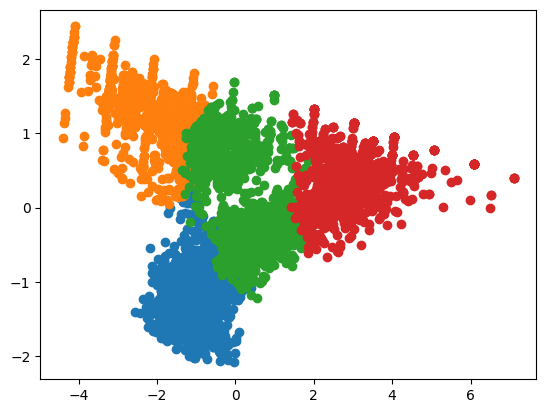

In [84]:
import matplotlib.pyplot as plt
%matplotlib inline
for i in customer_clustering["cluster"].unique():
    tmp = pca_df.loc[pca_df["cluster"]==i]
    plt.scatter(tmp[0], tmp[1])

### ノック35：クラスタリング結果をもとに退会顧客の傾向を把握しよう

In [85]:
customer_clustering = pd.concat([customer_clustering, customer], axis=1)
customer_clustering.groupby(["cluster", "is_deleted"], as_index=False)["customer_id"].count()

,cluster,is_deleted,customer_id
0,0,0,785
1,0,1,549
2,1,0,827
3,1,1,19
4,2,1,763
5,3,0,1230
6,3,1,19


In [86]:
customer_clustering.groupby(["cluster", "routine_flg"], as_index=False)["customer_id"].count()

,cluster,routine_flg,customer_id
0,0,0,228
1,0,1,1106
2,1,0,52
3,1,1,794
4,2,0,497
5,2,1,266
6,3,0,2
7,3,1,1247


### ノック36：翌月の利用回数予測を行うためのデータ準備をしよう

In [87]:
uselog["usedate"] = pd.to_datetime(uselog["usedate"])
uselog["年月"] = uselog["usedate"].dt.strftime("%Y%m")
uselog_months = uselog.groupby(["年月", "customer_id"], as_index=False)["log_id"].count()
uselog_months.rename(columns={"log_id":"count"}, inplace=True)
uselog_months.head()

,年月,customer_id,count
0,201804,AS002855,4
1,201804,AS009013,2
2,201804,AS009373,3
3,201804,AS015315,6
4,201804,AS015739,7


In [91]:
year_months = list(uselog_months["年月"].unique())
predict_data = pd.DataFrame()
for i in range(6, len(year_months)):
    tmp = uselog_months.loc[uselog_months["年月"]==year_months[i]].copy()
    tmp.rename(columns={"count":"count_pred"}, inplace=True)
    for j in range(1, 7):
      tmp_before = uselog_months.loc[uselog_months["年月"]==year_months[i-j]]
      del tmp_before["年月"]
      tmp_before.rename(columns={"count":"count_{}".format(j-1)}, inplace=True)
      tmp = pd.merge(tmp, tmp_before, on="customer_id", how="left")
    predict_data = pd.concat([predict_data, tmp], ignore_index=True)
predict_data.head()

<ipython-input-91-f35028db23ec>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_before.rename(columns={"count":"count_{}".format(j-1)}, inplace=True)
<ipython-input-91-f35028db23ec>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_before.rename(columns={"count":"count_{}".format(j-1)}, inplace=True)
<ipython-input-91-f35028db23ec>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_before.rename(columns={"count":"count_{}".fo

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS008805,2,2.0,5.0,7.0,8.0,NaN,NaN
2,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
3,201810,AS015233,7,9.0,11.0,5.0,7.0,7.0,NaN
4,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0


In [92]:
predict_data = predict_data.dropna()
predict_data = predict_data.reset_index(drop=True)
predict_data.head()

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0


### ノック37：特徴となる変数を付与しよう

In [93]:
predict_data = pd.merge(predict_data, customer[["customer_id", "start_date"]], on="customer_id", how="left")
predict_data.head()

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01


In [94]:
predict_data["now_date"] = pd.to_datetime(predict_data["年月"], format="%Y%m")
predict_data["start_date"] = pd.to_datetime(predict_data["start_date"])
from dateutil.relativedelta import relativedelta
predict_data["period"] = None
for i in range(len(predict_data)):
    delta = relativedelta(predict_data.loc[i, "now_date"], predict_data.loc[i, "start_date"])
    predict_data.loc[i, "period"] = delta.years*12 + delta.months
predict_data.head()

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date,now_date,period
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01,2018-10-01,23
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01,2018-10-01,35
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01,2018-10-01,39
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01,2018-10-01,16
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01,2018-10-01,12


### ノック38：来月の利用回数予測モデルを作成しよう

In [96]:
predict_data = predict_data.loc[predict_data["start_date"]>=pd.to_datetime("20180401")]
from sklearn import linear_model
import sklearn.model_selection
model = linear_model.LinearRegression()
X = predict_data[["count_0", "count_1", "count_2", "count_3", "count_4", "count_5", "period"]]
y = predict_data["count_pred"]
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y)
model.fit(X_train, y_train)

LinearRegression()

In [97]:
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.6210669712766983
0.564453895036865


### ノック39：モデルに寄与している変数を確認しよう

In [98]:
coef = pd.DataFrame({"feature_names":X.columns, "coefficient":model.coef_})
coef

,feature_names,coefficient
0,count_0,0.339841
1,count_1,0.225199
2,count_2,0.149553
3,count_3,0.173891
4,count_4,0.094114
5,count_5,0.055461
6,period,0.069934


### ノック40：来月の利用回数を予測しよう

In [99]:
x1 = [3, 4, 4, 6, 8, 7, 8]
x2 = [2, 2, 3, 3, 4, 6, 8]
x_pred = pd.DataFrame(data=[x1, x2],columns=["count_0", "count_1", "count_2", "count_3", "count_4", "count_5", "period"])

In [100]:
model.predict(x_pred)

array([3.81286137, 1.91948264])

In [101]:
uselog_months.to_csv("uselog_months.csv", index=False)